In [1]:
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import importlib
from src import model_save_load
import open3d as o3d
import numpy as np
importlib.reload(model_save_load)
# from model_save_load import load_mesh
from src import object_render
importlib.reload(object_render)
# from object_render import get_render
from src import convex_decomposition
importlib.reload(convex_decomposition)
from src import object_detection
importlib.reload(object_detection)
from src import bbox_utils
importlib.reload(bbox_utils)
# from convex_decomposition import create_default_convex_decomposition


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


<module 'src.bbox_utils' from 'd:\\work\\projects\\FunctionalGrasp\\Affordance\\src\\bbox_utils.py'>

In [2]:
data_dir = Path("./data/hammer")
initial_mesh_file = data_dir / "initial_mesh.ply"
mesh_o3d, mesh_trimesh, info = model_save_load.load_mesh(initial_mesh_file, vis=False)

In [3]:
# decomposition can take a long time, the result is saved in the data_dir in the obj format
if (data_dir/"object_convex_decomposition.obj").exists():
    mesh = o3d.io.read_triangle_mesh(data_dir/"object_convex_decomposition.obj")
else: 
    mesh = convex_decomposition.create_default_convex_decomposition(mesh_o3d, data_dir,  vis=True)

In [5]:
o3d.visualization.draw_geometries([mesh], mesh_show_wireframe=True, mesh_show_back_face=True)

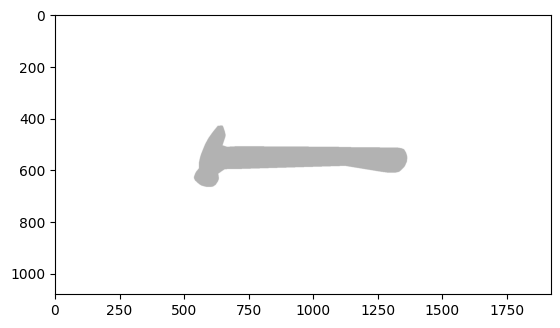

In [8]:
# render the decomposed mesh
render, depth = object_render.get_render(90, 45, mesh)

cv2.imwrite(data_dir/"render.png", render)
cv2.imwrite(data_dir/"depth.png", depth)
plt.imshow(render)

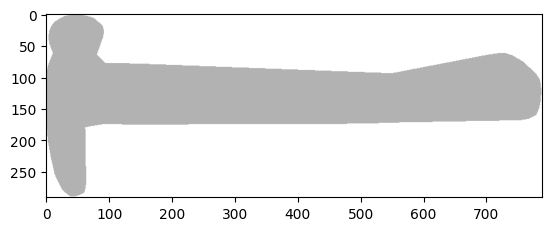

In [15]:
bbox = object_detection.detect_object_with_opencv(render, vis=False)
croped_image = bbox_utils.crop_bbox_cv2(render, bbox)
plt.imshow(croped_image)

In [16]:
bbox

[569, 394, 1357, 684]

[565 389 671 684]
[569 406 664 684]
[567 400 687 687]


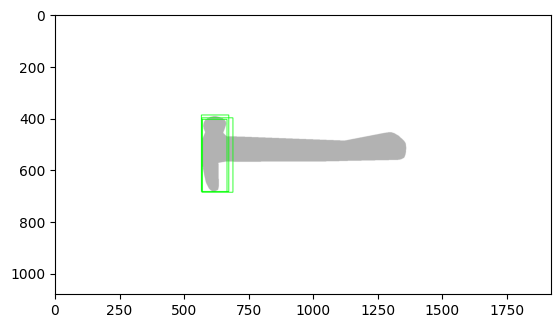

In [6]:
bboxes = object_detection.get_bounding_boxes(render)
vis_render  = render.copy() # copy is enough to apply the bboxes to only the vis_render
for bbox in bboxes:
    print(bbox)
    bbox_utils.add_bbox(vis_render, bbox, color=(0, 255, 0), thickness=2)

plt.imshow(vis_render)

In [7]:
bboxes

array([[565, 389, 671, 684],
       [569, 406, 664, 684],
       [567, 400, 687, 687]])

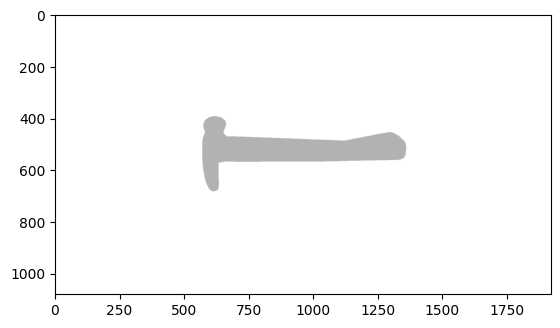

In [8]:
plt.imshow(render)

M [[ 1.46931169e+00 -1.50053230e-01  2.33500584e+02]
 [ 1.50053230e-01  1.46931169e+00  2.91038447e+02]]


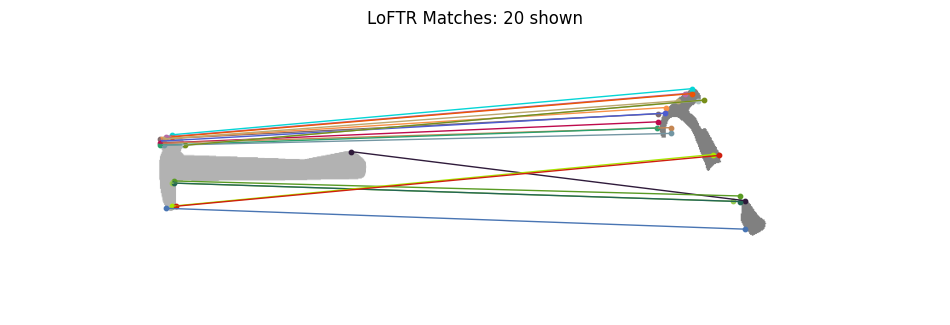

In [9]:
from src.feature_matching import get_matching_transformation, bbox_to_corners, transform_corners
hand_bbox = np.array([225, 158, 275, 222])
mask = cv2.imread(data_dir/"mask.png")
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
M = get_matching_transformation(render, mask, vis=True)
corners = bbox_to_corners(hand_bbox)
corners = transform_corners(corners, M)

In [10]:
import cv2
import numpy as np

# Load images
img1 = render # Query image (object in hand)
img2 =  mask  # Train image (isolated object)

# Initialize ORB detector
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# Match features using Brute-Force
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

# Draw top 10 matches
matched_img = cv2.drawMatches(img1, kp1, img2, kp2, matches[:10], None, flags=2)
cv2.imshow('Matches', matched_img)
cv2.waitKey(0)
cv2.destroyAllWindows()